In [155]:
from __future__ import absolute_import, division
import glob
import os
import re
import json
from astropy.io import fits as fits
import matplotlib.dates as mdates
import torch
import h5py
import datetime
import numpy as np
import matplotlib

import torch.nn.functional as F

#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
this_dir = os.getcwd()

import matplotlib as mpl
# try to use the precise epoch
mpl.rcParams['date.epoch']='1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

from tqdm import tqdm
%matplotlib inline

import matplotlib.style as mplstyle
mplstyle.use('fast')


%load_ext autotime

%load_ext autoreload
%autoreload 2


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 127 ms (started: 2022-07-06 23:54:48 +03:00)


In [2]:
import gc
gc.collect()

0

time: 98 ms (started: 2022-07-06 22:33:54 +03:00)


In [5]:
os.getcwd()

'/discofs/pjer1316'

time: 101 ms (started: 2022-07-06 22:34:53 +03:00)


In [7]:
# add current path as python path
import sys
this_dir = os.getcwd()
sys.path.append('/discofs/pjer1316/E20220519/proc/')

time: 93.7 ms (started: 2022-07-06 22:36:08 +03:00)


In [8]:
pwd

'/discofs/pjer1316'

time: 14.3 ms (started: 2022-07-06 22:36:13 +03:00)


In [9]:
x_points = 900 # time sample points
y_points = -1 # f samples  (-1 for not down sampling, keep origional) 
chunk_t = datetime.timedelta(minutes=15)
chop_off = False # chop every **interger** 15 minutes [00:15,00:30,00:45....]

# IMORTANT!! give absolute (or relative) paths to the next array: first of the calibrator, and then of the target source
h5dir = '../H5/'
out_dir_base = '../h5testdata/out/' # should be absolute dir starting from '/'
#calibrator_name = 'Cassiopeia A'

h5_fname = 'L860566_SAP000_B000_S0_P000_bf.h5'

work_dir = '/discofs/pjer1316/E20220519/proc/'
#os.getcwd()

time: 13.8 ms (started: 2022-07-06 22:36:14 +03:00)


In [10]:
os.chdir(work_dir) # go back home
os.chdir(h5dir)
m = re.search('B[0-9]{3}', h5_fname)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', h5_fname)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File( h5_fname, 'r' )
group = f['/']
        #keys = sorted(['%s'%item for item in sorted(list(group.attrs))])
        
        # obtain name of calibrator
target_obs = group.attrs['TARGETS']
calibrator_name = [x for x in target_obs if x!='Sun'][0]
        
data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape
#data_lightcurve_cal=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][:,600]

time: 12.7 ms (started: 2022-07-06 22:36:14 +03:00)


In [11]:
total_t=f['/'].attrs['TOTAL_INTEGRATION_TIME']

freq = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_1'].attrs['AXIS_VALUES_WORLD']/1e6

data_shape

(2746560, 6400)

time: 12.1 ms (started: 2022-07-06 22:36:14 +03:00)


In [12]:
t0_idx = 2500#1800000

time: 10.3 ms (started: 2022-07-06 22:36:14 +03:00)


In [193]:
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*80,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]
data_test = data_test/data_test[0,:]

time: 177 ms (started: 2022-07-06 13:19:27 +03:00)


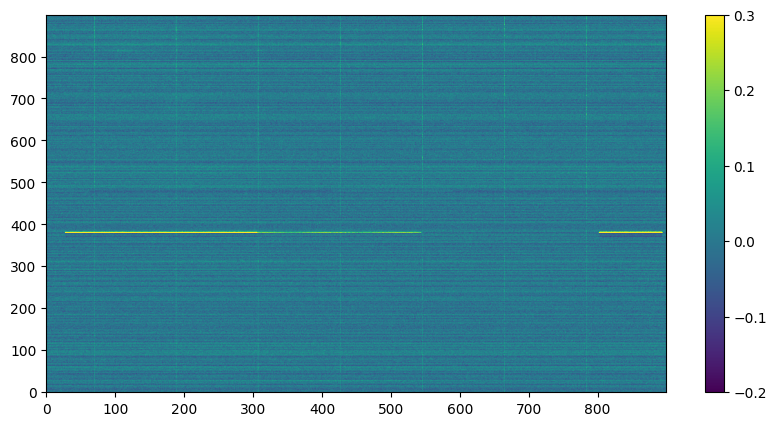

time: 709 ms (started: 2022-07-06 13:19:30 +03:00)


In [194]:
plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(data_test).T[2000:2900,0:900],interpolation=None,aspect='auto',origin='lower',vmax=0.3,vmin=-0.2)
#plt.xlim(2000,3000)
#plt.ylim(5000,6000)
plt.colorbar()

In [324]:

import torch.nn.functional as F

# reload data
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*60*10,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]


# increase dimention of array


time: 1.13 s (started: 2022-07-07 13:08:31 +03:00)


In [325]:
import sys
sys.getsizeof(data_test)/(1024**3) # in GB

1.373291127383709

time: 15.4 ms (started: 2022-07-07 13:08:36 +03:00)


In [326]:
freq_window=16
time_window=192

conv_down =  F.conv2d(torch.tensor(data_test[None,None,:,:]),
    torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
    stride=(time_window,freq_window),padding=(0,0))

avg_spec = conv_down.squeeze()

time: 55.9 ms (started: 2022-07-07 13:08:36 +03:00)


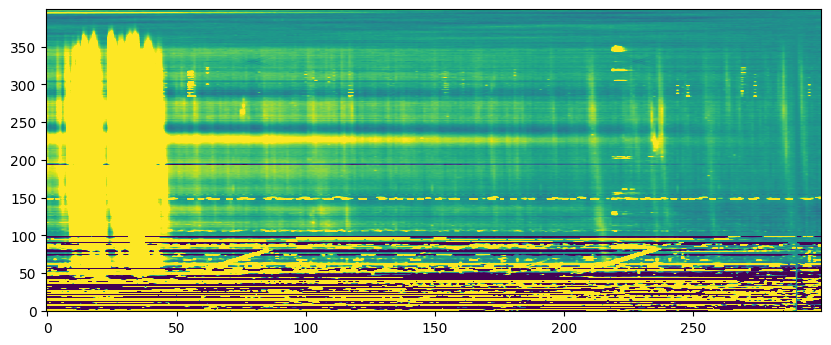

time: 219 ms (started: 2022-07-07 13:08:39 +03:00)


In [327]:

avg_spec_plot = avg_spec/avg_spec[-10,:]

plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(avg_spec_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=0.02,vmin=-0.02)

In [330]:

from RFIconvFlag import *

net = init_net(net,[1.6,1.65])


with torch.no_grad():
    output = net(torch.tensor(data_test.squeeze()[None,None,:,:])).squeeze().numpy()


time: 341 ms (started: 2022-07-07 13:09:59 +03:00)


In [331]:

#data_test_ma = np.ma.masked_where((output.squeeze()),data_test.squeeze())

time: 13.7 ms (started: 2022-07-07 13:10:01 +03:00)


In [332]:
data_test.shape

(57600, 6400)

time: 17.3 ms (started: 2022-07-07 13:10:01 +03:00)


In [333]:

for shift in (-1,1):
    for axis in (0,1):        
        msk_shifted=np.roll(output,shift=shift,axis=axis)
        data_shift = np.roll(data_test,shift=shift,axis=axis)
        idx=~msk_shifted* output
        data_test[idx]=data_shift[idx]

time: 3.2 s (started: 2022-07-07 13:10:02 +03:00)


In [334]:

conv_down_after_flag =  F.conv2d(torch.tensor(data_test[None,None,:,:]),
    torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
    stride=(time_window,freq_window),padding=(0,0))

time: 146 ms (started: 2022-07-07 13:10:09 +03:00)


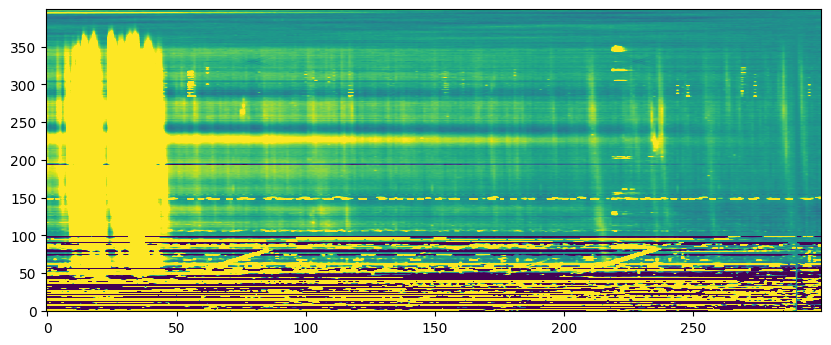

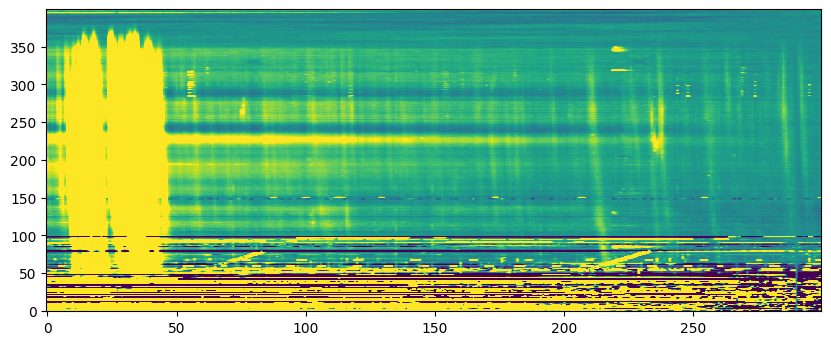

time: 393 ms (started: 2022-07-07 13:10:09 +03:00)


In [335]:
avg_spec2=conv_down_after_flag.squeeze()
avg_spec2_plot = avg_spec2/avg_spec2[-10,:]


plt.figure(figsize=(10,4),dpi=100)
plt.imshow( np.log10(avg_spec_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=0.02,vmin=-0.02)
plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(avg_spec2_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=0.02,vmin=-0.02)

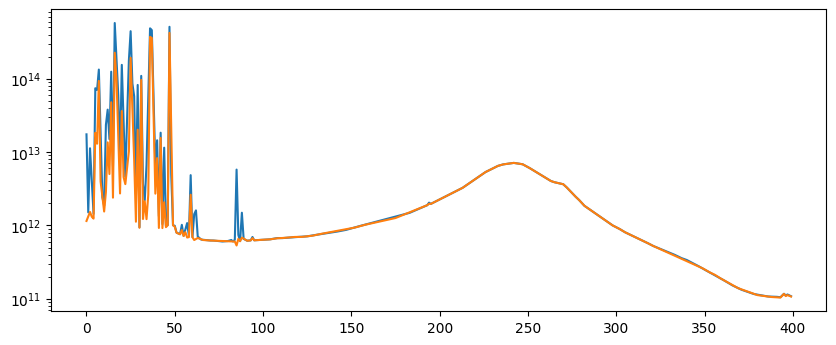

time: 255 ms (started: 2022-07-07 13:10:10 +03:00)


In [336]:
plt.figure(figsize=(10,4),dpi=100)

plt.plot(avg_spec[5,:])
plt.plot(avg_spec2[5,:])
plt.yscale('log')

In [337]:
avg_spec2-avg_spec

tensor([[-8.3616e+12, -9.6466e+10, -4.6888e+12,  ..., -7.7220e+08,
         -9.2474e+08, -1.1106e+09],
        [-1.3311e+13, -9.1782e+10, -7.2327e+12,  ..., -2.5865e+08,
         -9.5315e+08, -8.4440e+08],
        [-1.8521e+13, -2.1055e+11, -5.2725e+12,  ..., -8.8957e+07,
         -9.7967e+08, -8.7169e+08],
        ...,
        [-3.2444e+12, -1.2640e+11, -6.1278e+12,  ..., -6.6680e+08,
         -8.7280e+08, -1.0011e+09],
        [-2.7617e+12, -4.9860e+10, -7.3392e+12,  ..., -5.6769e+08,
         -8.0605e+08, -9.4036e+08],
        [-2.2414e+12, -7.0434e+10, -7.3566e+12,  ..., -3.1565e+08,
         -7.0479e+08, -9.7279e+08]])

time: 16.4 ms (started: 2022-07-07 13:10:14 +03:00)


In [338]:
data_sampling=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*800:192,::32]

time: 17 s (started: 2022-07-07 13:10:14 +03:00)


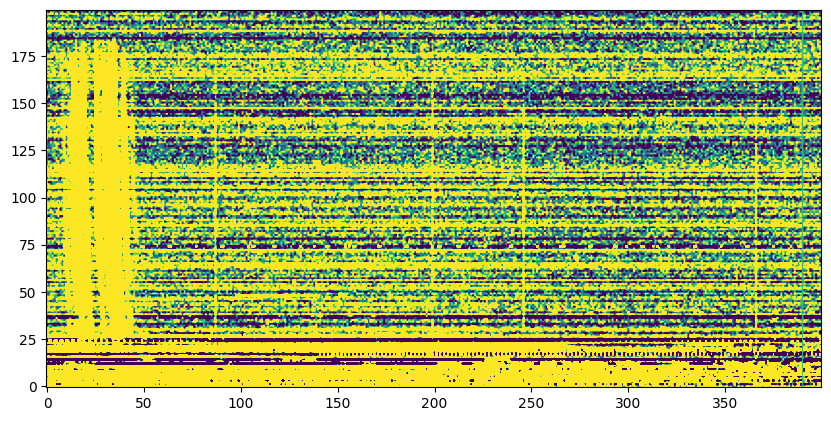

time: 186 ms (started: 2022-07-07 13:10:31 +03:00)


In [339]:

data_sampling = data_sampling/data_sampling[-10,:]

plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(data_sampling).T,interpolation=None,aspect='auto',origin='lower',vmax=0.02,vmin=-0.04)

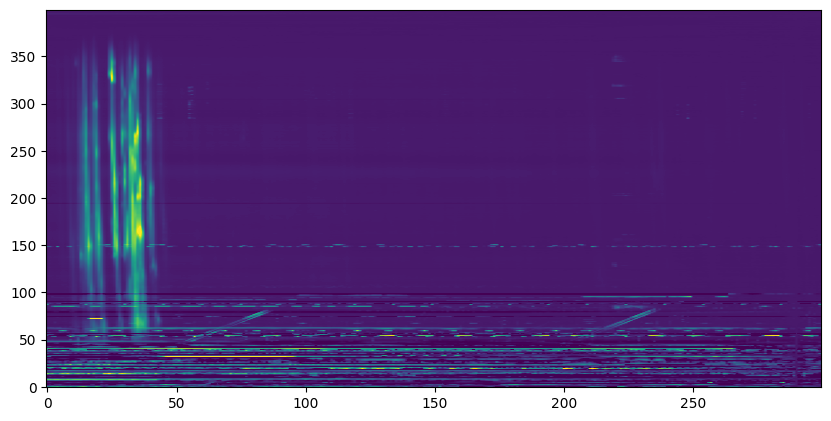

time: 161 ms (started: 2022-07-07 13:10:32 +03:00)


In [340]:

plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(avg_spec_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=1.4,vmin=-0.1)

In [465]:
total_t/data_shape[0]

0.01048576

time: 92.8 ms (started: 2022-07-08 15:31:34 +03:00)


In [644]:
t0_idx = 2500
t_duration_idx = 96*60*4
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+t_duration_idx,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]
#data_test = data_test/data_test[0,:]


print(sys.getsizeof(data_test)/(1024**3)) # in GB

0.549316518008709
time: 623 ms (started: 2022-07-08 17:32:23 +03:00)


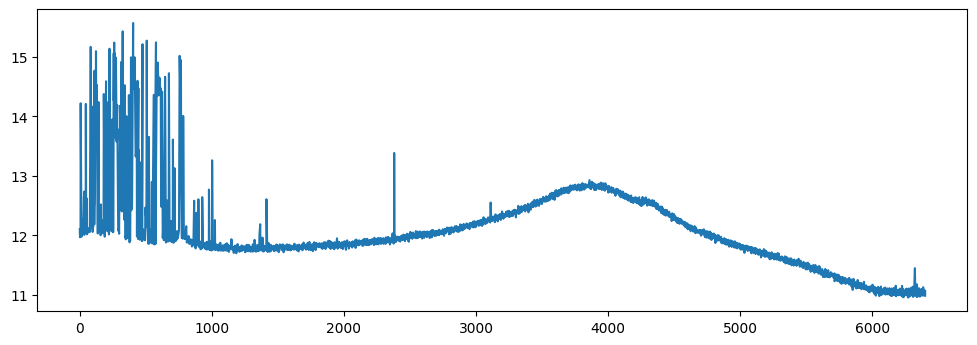

time: 99.3 ms (started: 2022-07-08 17:32:24 +03:00)


In [645]:
plt.figure(figsize=(12,4),dpi=100)

plt.plot(np.log10(data_test[300,:]))

In [646]:
#net = init_net(net,[1.6,1.65])
from RFIconvFlag import  RFIconv,init_RFIconv
net = RFIconv()

factors = [[0.01,0.01,0.45,0.45],[1.66,1.6,0.01,0.01],[1.66,1.6,0.45,0.45]]

data_test_ma_0 =[]

for agg_factor in factors:

    net = init_RFIconv(net,aggressive_factor = agg_factor)
    with torch.no_grad():
        output = net(torch.tensor(data_test.squeeze()[None,None,:,:])).squeeze().numpy()
    data_test_ma = np.ma.masked_where((output),data_test.squeeze())
    data_test_ma_0.append(data_test_ma)


time: 10.2 s (started: 2022-07-08 17:32:24 +03:00)


In [647]:
torch.tensor(data_test.squeeze()[None,None,:,:])

tensor([[[[1.6652e+12, 1.7400e+12, 1.0917e+12,  ..., 1.0210e+11,
           1.1294e+11, 1.0491e+11],
          [1.4247e+12, 1.7499e+12, 1.2658e+12,  ..., 1.0156e+11,
           9.9122e+10, 1.0751e+11],
          [1.4504e+12, 1.9047e+12, 1.1891e+12,  ..., 1.1285e+11,
           1.0020e+11, 1.1943e+11],
          ...,
          [1.7620e+12, 3.9193e+13, 1.0249e+12,  ..., 9.8492e+10,
           1.0620e+11, 1.0162e+11],
          [1.4676e+12, 3.7456e+13, 8.9314e+11,  ..., 1.1077e+11,
           1.1440e+11, 1.0251e+11],
          [1.3385e+12, 3.8391e+13, 9.2601e+11,  ..., 1.0031e+11,
           1.1066e+11, 9.8121e+10]]]])

time: 32.7 ms (started: 2022-07-08 17:32:34 +03:00)


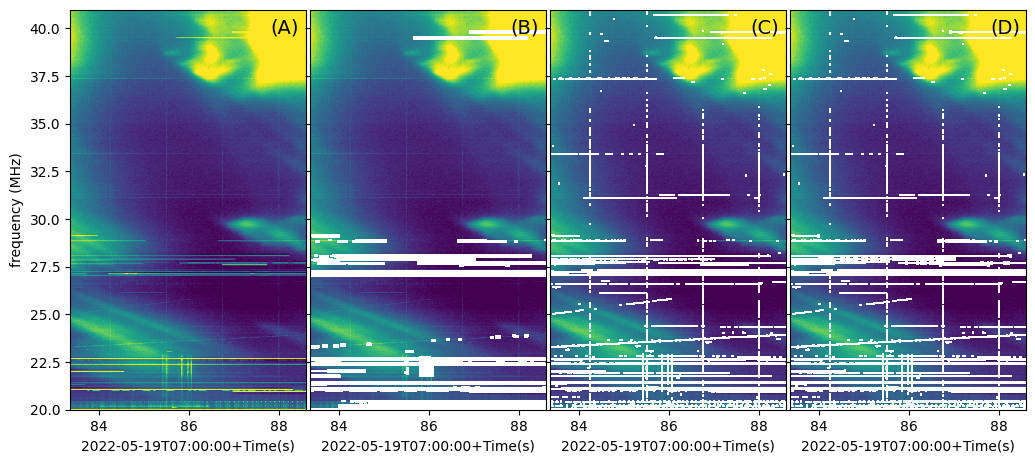

time: 982 ms (started: 2022-07-08 17:38:05 +03:00)


In [661]:
t_idx0,t_idx1,f_idx0,f_idx1 = 5050,5850,782,3200
t_idx0,t_idx1,f_idx0,f_idx1 = 5450,5950,782,2500


fig = plt.figure(figsize=(8,5),dpi=100)
ax1 = fig.add_axes([0.1,0.1,0.3-0.005,0.8])
ax1.imshow(np.log10(data_test.squeeze()[t_idx0:t_idx1,f_idx0:f_idx1]).T,
    interpolation=None,aspect='auto',origin='lower',vmax=12.3,vmin=11.8,
    extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_idx1+t0_idx)*total_t/data_shape[0],
    freq[f_idx0],freq[f_idx1]])
plt.setp(ax1, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)', ylabel='frequency (MHz)')
# text on upper left corner
ax1.text(0.85, 0.94, '(A)', transform=ax1.transAxes, fontsize=14)

texthub = ['(B)','(C)','(D)']
for idxtmp in range(3):
    ax2 = fig.add_axes([0.4+0.3*idxtmp,0.1,0.3-0.005,0.8])
    ax2.imshow(np.log10(data_test_ma_0[idxtmp][t_idx0:t_idx1,f_idx0:f_idx1]).T,
        interpolation=None,aspect='auto',origin='lower',vmax=12.3,vmin=11.8,
        extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_idx1+t0_idx)*total_t/data_shape[0],
        freq[f_idx0],freq[f_idx1]])
    plt.setp(ax2, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)',yticklabels=[])
    
    ax2.text(0.85, 0.94, texthub[idxtmp], transform=ax2.transAxes, fontsize=14)

fig.savefig(work_dir+'/RFIconv.pdf',bbox_inches='tight')

In [649]:
F.relu

<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

time: 20.2 ms (started: 2022-07-08 17:32:37 +03:00)


In [650]:
time_window=64
freq_window=32

conv_down_direct =  F.conv2d(torch.tensor(data_test[None,None,:,:]),
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


conv_down_after_flag =  F.conv2d(torch.tensor(data_test[None,None,:,:]*(~output[None,None,:,:])),
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


conv_down_weight_after_flag =  F.conv2d(torch.tensor(1-output[None,None,:,:])*1.0,
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


small_arr  =  conv_down_after_flag/conv_down_weight_after_flag

time: 500 ms (started: 2022-07-08 17:32:37 +03:00)


In [651]:

dum0 = torch.tensor([0.0])
small_torch  =torch.tensor(small_arr)

time: 18.5 ms (started: 2022-07-08 17:32:38 +03:00)


In [652]:
small_torch.dtype

torch.float32

time: 13.2 ms (started: 2022-07-08 17:32:38 +03:00)


In [653]:
for i in range(20000):
    torch.heaviside(small_torch,dum0)
    #F.relu(small_torch)

time: 703 ms (started: 2022-07-08 17:32:38 +03:00)


In [654]:
np.where(conv_down_weight_after_flag==0)[0].shape

(0,)

time: 14.7 ms (started: 2022-07-08 17:32:39 +03:00)


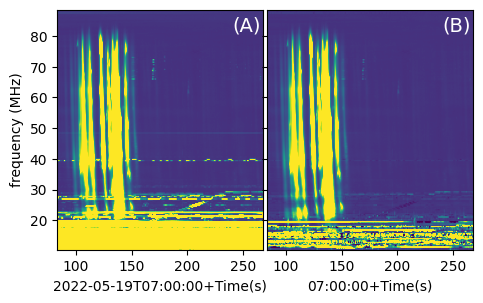

time: 422 ms (started: 2022-07-08 18:04:01 +03:00)


In [665]:

small_arr  =  conv_down_after_flag/conv_down_weight_after_flag

bdps=[]
for frq_idx in range(small_arr.shape[1]):
    bdps.append( partition_avg(small_arr[:,frq_idx],(0.02,0.2)))
bdps = np.array(bdps)


fig=plt.figure(figsize=(7,3.),dpi=100)
ax1 = fig.add_axes([0.1,0.1,0.3-0.005,0.8])
ax1.imshow(np.log10(conv_down_direct/bdps[None:,]).T,
    interpolation=None,aspect='auto',origin='lower',vmax=0.3,vmin=-0.05,
    extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_duration_idx+t0_idx)*total_t/data_shape[0],
    freq[0],freq[-1]])
plt.setp(ax1, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)', ylabel='frequency (MHz)')
# text on upper left corner
ax1.text(0.85, 0.91, '(A)',color='w', transform=ax1.transAxes, fontsize=14)


texthub = ['(B)','(C)','(D)']
for idxtmp in range(1):
    ax2 = fig.add_axes([0.4+0.3*idxtmp,0.1,0.3-0.005,0.8])
    ax2.imshow(np.log10(small_arr/bdps[None,:]).T,
        interpolation=None,aspect='auto',origin='lower',vmax=0.3,vmin=-0.05,
        extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_duration_idx+t0_idx)*total_t/data_shape[0],
        freq[0],freq[-1]])
    plt.setp(ax2, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][11:19]+'+Time(s)',yticklabels=[])
    
    ax2.text(0.85, 0.91, texthub[idxtmp], color='w', transform=ax2.transAxes, fontsize=14)

fig.savefig(work_dir+'/RFIconvTypeIII.pdf',bbox_inches='tight')

#plt.imshow(np.log10(conv_down_direct/bdps[None:,]).T,interpolation=None,aspect='auto',origin='lower',
#vmax=0.4,vmin=-0.01)
#plt.ylim(1300,1800)




In [267]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  

12
torch.Size([1, 1, 3, 3])
time: 1.26 s (started: 2022-07-07 11:31:01 +03:00)


In [268]:
from tqdm import tqdm

"""

    data_test_ma = np.ma.masked_where((output.squeeze()),data_test.squeeze())
    for shift in (-1,1):
        for axis in (0,1):        
            a_shifted=np.roll(data_test_ma,shift=shift,axis=axis)
            idx=~a_shifted.mask * data_test_ma.mask
            data_test_ma[idx]=a_shifted[idx]
"""

'\n\n    data_test_ma = np.ma.masked_where((output.squeeze()),data_test.squeeze())\n    for shift in (-1,1):\n        for axis in (0,1):        \n            a_shifted=np.roll(data_test_ma,shift=shift,axis=axis)\n            idx=~a_shifted.mask * data_test_ma.mask\n            data_test_ma[idx]=a_shifted[idx]\n'

time: 15 ms (started: 2022-07-07 11:31:09 +03:00)


In [320]:
freq_window=16
time_window=192

chunk_len = 96*60*10
big_arr = []


net = init_RFIconv(net,aggressive_factor = [1.6,1.8,0.5,0.5])

for num_chunk in tqdm(range(int((data_shape[0]-96*60*100)/chunk_len))):
    data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][
        chunk_len*num_chunk:chunk_len*(num_chunk+1),:]
    
    # no grad:
    with torch.no_grad():
        output = net(torch.tensor(data_test[None,None,:,:])).squeeze().numpy()

        conv_down_after_flag =  F.conv2d(torch.tensor(data_test[None,None,:,:]*(~output[None,None,:,:])),
                torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
                stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


        conv_down_weight_after_flag =  F.conv2d(torch.tensor(1-output[None,None,:,:])*1.0,
                torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
                stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


        small_arr  =  conv_down_after_flag/conv_down_weight_after_flag
                        

    big_arr.append(small_arr)

100%|██████████| 36/36 [05:10<00:00,  8.62s/it]

time: 5min 10s (started: 2022-07-07 13:01:54 +03:00)


In [321]:
big_arr_plot = np.concatenate(big_arr,axis=0)


time: 122 ms (started: 2022-07-07 13:07:55 +03:00)


In [322]:
def partition_avg(arr, ratio_range):
    #  average in a given ratio range to exclude extreme value
    arr_sort = np.sort(arr.ravel())
    nums = arr_sort[int(ratio_range[0]*arr_sort.shape[0]):int(ratio_range[1]*arr_sort.shape[0])]
    return np.mean(nums)

time: 14.8 ms (started: 2022-07-07 13:07:56 +03:00)


Text(0.5, 0, 'Time (minute) from 2022-05-19T07:00:00.000000000Z')

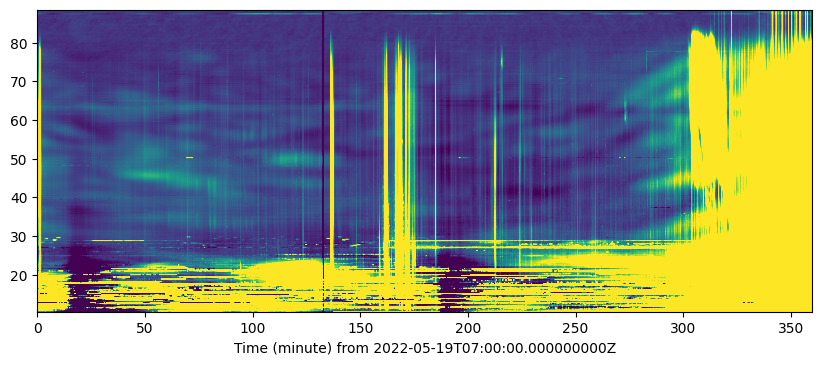

time: 678 ms (started: 2022-07-07 13:07:57 +03:00)


In [323]:
time_minute = np.arange(big_arr_plot.shape[0])*2/60

bdps=[]
for frq_idx in range(big_arr_plot.shape[1]):
    bdps.append( partition_avg(big_arr_plot[:,frq_idx],(0.15,0.2)))

bdps = np.array(bdps)

big_arr_plot_final = big_arr_plot/bdps
plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(big_arr_plot_final).T,interpolation=None,aspect='auto',origin='lower',vmax=0.09,vmin=-0.015,
    extent=[time_minute[0],time_minute[-1],freq[0],freq[-1]])

plt.xlabel('Time (minute) from '+f['/'].attrs['OBSERVATION_START_UTC'])

(5500000000000.0, 7000000000000.0)

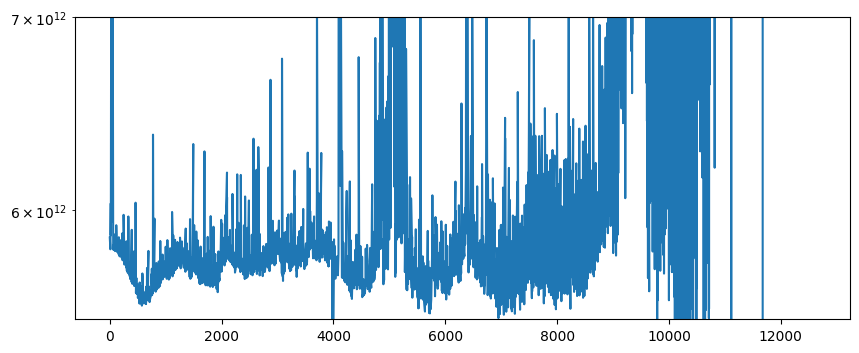

time: 174 ms (started: 2022-07-07 13:01:42 +03:00)


In [318]:

plt.figure(figsize=(10,4),dpi=100)
plt.plot((big_arr_plot[:,251]))
plt.yscale('log')
plt.ylim([5.5e12,7e12])

Text(0.5, 0, 'Time (minute) from 2022-05-19T07:00:00.000000000Z')

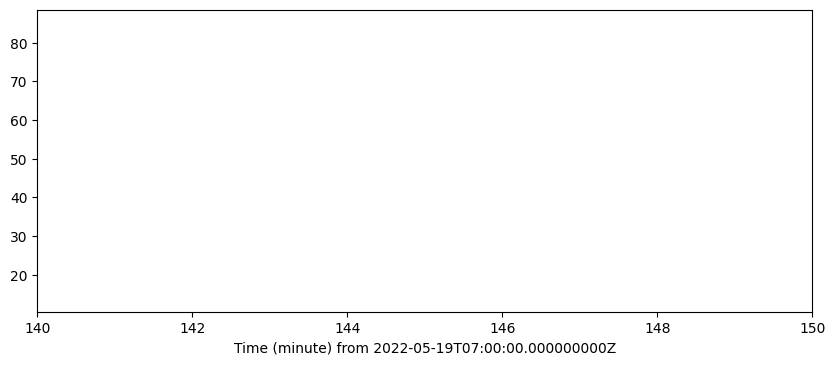

time: 94.9 ms (started: 2022-07-07 12:50:35 +03:00)


In [309]:

plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(big_arr_plot_final).T,interpolation=None,aspect='auto',origin='lower',vmax=0.05,vmin=-0.015,
    extent=[time_minute[0],time_minute[-1],freq[0],freq[-1]])
plt.xlim([140,150])

plt.xlabel('Time (minute) from '+f['/'].attrs['OBSERVATION_START_UTC'])

time: 398 µs (started: 2022-07-06 00:28:01 +03:00)
